<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Head-On Black Hole Collision

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module implements a basic numerical relativity code to merge two black holes in *spherical coordinates*

### Here we place the black holes initially on the $z$-axis, so the entire simulation is axisymmetric about the $\phi$-axis. Not sampling in the $\phi$ direction greatly speeds up the simulation.

**Notebook Status:** <font color = green><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution *after a short numerical evolution of the initial data* (see [plots at bottom](#convergence)), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy).

### NRPy+ Source Code & Tutorials for this module: 
* [BSSN/BrillLindquist.py](../edit/BSSN/BrillLindquist.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb): Brill-Lindquist initial data; sets all ADM variables in Cartesian basis: 
* [BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Exact_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Exact_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): Spherical/Cartesian ADM$\to$Curvilinear BSSN converter function, for which exact expressions are given for ADM quantities.
* [BSSN/BSSN_ID_function_string.py](../edit/BSSN/BSSN_ID_function_string.py): Sets up the C code string enabling initial data be set up in a point-by-point fashion
* [BSSN/BSSN_Ccodegen_library.py](../edit/BSSN/BSSN_Ccodegen_library.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-C_codegen_library.ipynb): Implements a number of helper functions for generating C codes from symbolic expressions generated in the following modules/tutorials:
    * [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
    * [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
    * [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates

## Introduction:
Here we use NRPy+ to generate the C source code necessary to set up initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on an [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4 is chosen below, but multiple options exist). 

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on Brill-Lindquist initial data**](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb)
    * [**NRPy+ tutorial on validating Brill-Lindquist initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_Exact_Initial_Data.ipynb).
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the Hamiltonian constraint violation 
        * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb).
    1. At each RK time substep, do the following:
        1. Evaluate BSSN RHS expressions 
            * [**NRPy+ tutorial on BSSN right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb) ([**BSSN Introduction Notebook**](Tutorial-BSSN_formulation.ipynb))
            * [**NRPy+ tutorial on BSSN gauge condition right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb) 
        1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
            * [**NRPy+ tutorial on setting up singular, curvilinear boundary conditions**](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)
        1. Enforce constraint on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
            * [**NRPy+ tutorial on enforcing $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint**](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#ccodegen): Generate C code kernels for BSSN expressions, in parallel if possible
    1. [Step 2.a](#rfm_ccodegen): Generate C code kernels for reference metric
1. [Step 3](#cparams_rfm_and_domainsize): Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters
1. [Step 4](#bc_functs): Set up boundary condition functions for chosen singular, curvilinear coordinate system
1. [Step 5](#mainc): `BrillLindquist_Playground`: The C code `main()` function
1. [Step 6](#compileexec): Compile generated C codes & perform the black hole collision calculation
1. [Step 7](#visualize): Visualize the output!
    1. [Step 7.a](#installdownload): Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 7.b](#genimages): Generate images for visualization animation
    1. [Step 7.c](#genvideo): Generate visualization animation
1. [Step 8](#convergence): Plot the numerical error at the end of the simulation, and confirm that it converges to zero with increasing numerical resolution (sampling)
1. [Step 9](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh, outCfunction, outC_function_dict, add_to_Cfunction_dict, outC_function_master_list # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
from pickling import pickle_NRPy_env, unpickle_NRPy_env  # NRPy+: Pickle/unpickle NRPy+ environment, for parallel codegen
import shutil, os, sys, time     # Standard Python modules for multiplatform OS-level functions, benchmarking

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("BSSN_Two_BHs_Collide_Ccodes_new_way")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step 1.a: Enable SIMD-optimized code?
#           I.e., generate BSSN and Ricci C code kernels using SIMD-vectorized
#           compiler intrinsics, which *greatly improve the code's performance*,
#           though at the expense of making the C-code kernels less
#           human-readable.
#           * Important note in case you wish to modify the BSSN/Ricci kernels
#             here by adding expressions containing transcendental functions
#             (e.g., certain scalar fields):
#           Note that SIMD-based transcendental function intrinsics are not
#           supported by the default installation of gcc or clang (you will
#           need to use e.g., the SLEEF library from sleef.org, for this
#           purpose). The Intel compiler suite does support these intrinsics
#           however without the need for external libraries.
enable_SIMD = True

# Step 1.b: Enable reference metric precomputation.
enable_rfm_precompute = True

if enable_SIMD and not enable_rfm_precompute:
    print("ERROR: SIMD does not currently handle transcendental functions,\n")
    print("       like those found in rfmstruct (rfm_precompute).\n")
    print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
    print("       is not supported.\n")
    sys.exit(1)

# Step 1.c: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = True

# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "Spherical"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()


# Step 2.a: Set outer boundary condition
# Current choices are extrapolation (quadratic polynomial extrapolation) or radiation
OuterBoundaryCondition = "radiation"
# OuterBoundaryCondition = "extrapolation"


# Step 2.b: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 7.5 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.c: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4            # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double"     # Best to use double here.
default_CFL_FACTOR= 0.5  # (GETS OVERWRITTEN IF SPECIFIED AT COMMAND LINE.)
                         # In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

In [2]:
# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Directory for reference_metric precomputation header files:
rfm_precompute_Ccode_outdir = os.path.join(Ccodesrootdir, "rfm_files/")
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesrootdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 7: Set finite_difference::enable_FD_functions appropriately. Defaults to False
if enable_FD_functions:
    par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 8: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

# Step 9: Set the direction=2 (phi) axis to be the symmetry axis; i.e.,
#         axis "2", corresponding to the i2 direction.
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")
OMP_pragma_on = "i1"  # structure OpenMP loops to parallelize, not over i2 (phi direction), but i1 (theta direction)

In [3]:
# Step 10: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 3-step process:
#       10.A: Evaluate RHSs (RHS_string)
#       10.B: Apply boundary conditions (post_RHS_string, pt 1)
#       10.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.MoL_new_way as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string      = """
Ricci_eval(params, rfmstruct, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(  params, rfmstruct, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);"""
if OuterBoundaryCondition == "extrapolation":
    # Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
    post_RHS_string = "apply_bcs_curvilinear_extrapolation(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, griddata->xx, RK_OUTPUT_GFS);"
elif OuterBoundaryCondition == "radiation":
    # Radiation (Sommerfeld) BCs are applied to the gridfunction RHSs directly
    RHS_string += "apply_bcs_curvilinear_radiation(params, bcstruct, NUM_EVOL_GFS, evol_gf_parity, griddata->xx, RK_INPUT_GFS, RK_OUTPUT_GFS);"
    post_RHS_string = ""
else:
    print("Invalid choice of boundary condition")
    sys.exit(1)

post_RHS_string += "enforce_detgammahat_constraint(params, rfmstruct, RK_OUTPUT_GFS);\n"

if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
    post_RHS_string = post_RHS_string.replace("rfmstruct", "xx")

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=False, enable_griddata=True)

<a id='ccodegen'></a>

# Step 2: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In the following code cell, we create a list of Python functions, which each registers a single C code function in `outputC`'s `outC_function_dict` dictionary. These Python functions are defined in 

1. the [`BSSN.BrillLindquist`](../edit/BSSN/BrillLindquist.py) NRPy+ module, which does the following:
    1. Sets up Brill-Lindquist initial data [ADM](https://en.wikipedia.org/wiki/ADM_formalism) quantities in the **Cartesian basis**, as [documented here](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb). 
    1. Converts the ADM **Cartesian quantities** to **BSSN quantities in the desired Curvilinear basis** (set by reference_metric::CoordSystem), as [documented here](Tutorial-ADM_Initial_Data-Converting_ADMCartesian_to_BSSNCurvilinear.ipynb).
    1. Sets up the standardized C function for setting all BSSN Curvilinear gridfunctions in a pointwise fashion, as [written here](../edit/BSSN/BSSN_ID_function_string.py), and returns the C function as a Python string.
1. the [`BSSN.BSSN_Ccodegen_library`](../edit/BSSN/BSSN_Ccodegen_library.py) NRPy+ module [\[**tutorial**\]](Tutorial-BSSN_time_evolution-C_codegen_library.ipynb), which contains Python functions for generating C code from symbolic expressions constructed within the following NRPy+ modules/tutorials:
    1. [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
    1. [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
    1. [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates
    1. [BSSN/Enforce_Detgammahat_Constraint.py](../edit/BSSN/Enforce_Detgammahat_Constraint.py); [**tutorial**](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb): Generates symbolic expressions for enforcing the $\det{\bar{\gamma}}=\det{\hat{\gamma}}$ constraint


Next, from within a `multiprocessing` environment, we then call all the Python C-code generation functions in this list in parallel (if `multiprocessing` is supported). This is quite useful, as these functions take several seconds to complete.

Within each `multiprocessing` process, the current NRPy+ environment is cloned, and a new function is registered to the `outC_function_dict` dictionary. Thus when each process completes, it contains a unique NRPy+ environment, with only its function registered. We address this by saving each process' NRPy+ environment and sending it back in a common binary format known as a `pickle`, using NRPy+'s [`pickling`](../edit/pickling.py) module. The environments are combined in an unpickling such that all functions exist within the same `outC_function_dict` dictionary.

To make the current environment fully consistent, we call `reference_metric.py` to register all its associated C functions (stored in globals) and contributions to `NRPy_basic_defines.h`.

In [4]:
# Step 2: Generate C code kernels for BSSN expressions, in parallel if possible;
import BSSN.BSSN_Ccodegen_library as BCL
import BSSN.BrillLindquist as bl
# Step 2.a: Create a list of functions we wish to evaluate in parallel (if possible)
# Create lists for all BSSN functions
BSSN_funcs = [bl.BrillLindquist]
BSSN_funcs.append(BCL.add_rhs_eval_to_Cfunction_dict)
BSSN_funcs.append(BCL.add_Ricci_eval_to_Cfunction_dict)
BSSN_funcs.append(BCL.add_BSSN_constraints_to_Cfunction_dict)
BSSN_funcs.append(BCL.add_enforce_detgammahat_constraint_to_Cfunction_dict)

# Step 2.b: Define master functions for parallelization.
#           Note that lambdifying this doesn't work in Python 3
def master_func(arg):
    if BSSN_funcs[arg] == bl.BrillLindquist:
        ret = BSSN_funcs[arg](include_NRPy_basic_defines_and_pickle=True)
    else:
        if enable_rfm_precompute:
            # We use rfm_precompute for all BSSN functions:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
            rfm.reference_metric()

        if BSSN_funcs[arg].__name__ == "add_BSSN_constraints_to_Cfunction_dict":
            ret = BSSN_funcs[arg](includes=["NRPy_basic_defines.h"],
                                  rel_path_to_Cparams=os.path.join("."), output_H_only=True,
                                  enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD,
                                  OMP_pragma_on=OMP_pragma_on)
        elif BSSN_funcs[arg].__name__ == "add_rhs_eval_to_Cfunction_dict" or \
            BSSN_funcs[arg].__name__ == "add_Ricci_eval_to_Cfunction_dict":
            ret = BSSN_funcs[arg](includes=["NRPy_basic_defines.h"],
                                  rel_path_to_Cparams=os.path.join("."),
                                  enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD,
                                  OMP_pragma_on=OMP_pragma_on)
        elif BSSN_funcs[arg].__name__ == "add_enforce_detgammahat_constraint_to_Cfunction_dict":
            ret = BSSN_funcs[arg](includes=["NRPy_basic_defines.h"],
                                  rel_path_to_Cparams=os.path.join("."),
                                  enable_rfm_precompute=enable_rfm_precompute, OMP_pragma_on=OMP_pragma_on)
        else:
            print("ERROR: DID NOT RECOGNIZE FUNCTION " + BSSN_funcs[arg].__name__ + "\n")
            sys.exit(1)
        if enable_rfm_precompute:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
            rfm.ref_metric__hatted_quantities()
    return ret


NRPyEnvVars = []
raised_exception = False
try:
    import platform
    os_name = platform.system() # Linux, Darwin, or Windows
    # Step 2.d: Import the multiprocessing module.
    if os_name == 'Windows':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in certain environments, e.g., Windows")
    elif os_name == "Darwin":
        # On Mac OS multiprocessing does not work as expected in Jupyter
        # notebooks, so we use multiprocess instead
        try:
            import multiprocess as mp
        except:
            error = "Could not load multiprocess. Please install it (e.g., `$ pip install multiprocess`) and try running this notebook again."
            raise ImportError(error)
    elif os_name == "Linux":
        # On Linux using multiprocessing does not seem to be a problem
        import multiprocessing as mp
    else:
        raise Exception(f"Unknown system {os_name}. Reverting to serial code generation.")

    # Step 2.e: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = mp.Pool()
    NRPyEnvVars.append(pool.map(master_func, range(len(BSSN_funcs))))
    pool.terminate()
    pool.join()
except:
    print("FAILED PARALLEL CODEGEN!")
    NRPyEnvVars = [] # Reset, as pickling/unpickling unnecessary for serial codegen (see next line)

    # Steps 2.d-e, alternate: As fallback, evaluate functions in serial.
    #       This will happen on Android and Windows systems
    for i, func in enumerate(BSSN_funcs):
        master_func(i)
    raised_exception = True

outCfunc_master_list = outC_function_master_list
if not raised_exception:
    outCfunc_master_list = unpickle_NRPy_env(NRPyEnvVars)
    for el in outCfunc_master_list:
        if el not in outC_function_master_list:  # in case there are duplicate funcs, which can happen
            #                                      if finite_difference_functions = True
            outC_function_master_list += [el]

Generating symbolic expressions for BSSN constraints (Spherical coords)...
Generating symbolic expressions for BSSN_RHSs (Spherical coords)...
Generating symbolic expressions for 3-Ricci tensor (Spherical coords)...
Generating C code for Enforcing det(gammabar)=det(gammahat) constraint (Spherical coords)...
Finished generating C code for Enforcing det(gammabar)=det(gammahat) constraint (Spherical coords) in 0.2 seconds.
Finished generating symbolic expressions for 3-Ricci tensor (Spherical coords) in 1.0 seconds. Next up: C codegen...
Generating C code for 3-Ricci tensor (FD order=4) (Spherical coords)...
Finished generating symbolic expressions for BSSN constraints (Spherical coords) in 1.6 seconds. Next up: C codegen...
Generating C code for BSSN constraints (FD order=4) (Spherical coords)...
Finished generating symbolic expressions for BSSN_RHSs (Spherical coords) in 3.4 seconds. Next up: C codegen...
Generating C code for BSSN_RHSs (FD order=4) (Spherical coords)...
Finished genera

<a id='rfm_ccodegen'></a>

## Step 2.a: Generate C code kernels for reference metric \[Back to [top](#toc)\]
$$\label{rfm_ccodegen}$$

In the [reference_metric](../edit/reference_metric.py) NRPy+ module, `register_C_functions_and_NRPy_basic_defines()` registers the following C functions to `outC_Cfunction_dict`:

1. `find_timestep()`: Finds the minimum spacing between adjacent gridpoints on our numerical grid $\min(ds_i)$, and sets the timestep according to the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition: $\Delta t \le \frac{\min(ds_i)}{c}$, where $c$ is the wavespeed, and $ds_i = h_i \Delta x^i$ is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction.
1. `xx_to_Cart()`: Input = uniformly sampled coordinate xx0,xx1,xx2 (e.g., r,theta,phi in Spherical coordinates). Output = Cartesian coordinate (x,y,z).
1. `set_Nxx_dxx_invdx_params__and__xx()`: Sets `Nxx{0,1,2}`, `Nxx_plus_2NGHOSTS{0,1,2}`, `dxx{0,1,2}`, and `invdx{0,1,2}`; and defines `xx[3][]`.
1. `Cart_to_xx_and_nearest_i0i1i2()`: Input = Cartesian coordinate (x,y,z). Output = uniformly sampled coordinate xx0,xx1,xx2 (e.g., r,theta,phi in Spherical coordinates), as well as corresponding grid index `i0,i1,i2`.

In [5]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function

# Sets reference_metric globals: NRPy_basic_defines_str, rfm_struct__malloc, rfm_struct__define, rfm_struct__freemem
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
    rfm.reference_metric()

rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute, use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
    rfm.ref_metric__hatted_quantities()

<a id='cparams_rfm_and_domainsize'></a>

# Step 3: Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters  \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

First we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above.

In [6]:
# Step 3.e.i: Set free_parameters.h
outstr = r"""// Set free-parameter values.
// Set the default CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+r""";

// Set free-parameter values for BSSN evolution:
params.eta = 1.0;

// Set free parameters for the (Brill-Lindquist) initial data
params.BH1_posn_x = 0.0; params.BH1_posn_y = 0.0; params.BH1_posn_z =+0.5;
params.BH2_posn_x = 0.0; params.BH2_posn_y = 0.0; params.BH2_posn_z =-0.5;
params.BH1_mass = 0.5; params.BH2_mass = 0.5;
"""

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='bc_functs'></a>

# Step 4: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs_new_way.ipynb)

In [7]:
import CurviBoundaryConditions.CurviBoundaryConditions_new_way as CBC
CBC.CurviBoundaryConditions_register_C_functions_and_NRPy_basic_defines()
CBC.add_to_Cfunction_dict_set_up__bc_gz_map_and_parity_condns()
# We always need extrapolation, to fill in lambdaU data on the outer boundaries at t=0 (in most cases it's unknown there):
CBC.add_to_Cfunction_dict_apply_bcs_curvilinear(outer_bcs_type="extrapolation")
if OuterBoundaryCondition == "radiation":
    CBC.add_to_Cfunction_dict_apply_bcs_curvilinear(outer_bcs_type=OuterBoundaryCondition)

Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" has parity type 1.
Evolved gridfunction "lambdaU1" has parity type 2.
Evolved gridfunction "lambdaU2" has parity type 3.
Evolved gridfunction "trK" has par

<a id='mainc'></a>

# Step 5: The C code `main()` function for `BrillLindquist_Playground` \[Back to [top](#toc)\]
$$\label{mainc}$$

In [8]:
def add_to_Cfunction_dict_main__BrillLindquist_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "time.h"]
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);

  // Step 0.a: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0.b: Read command-line input, error out if nonconformant
  if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
    fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
    fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  if(argc == 5) {
    CFL_FACTOR = strtod(argv[4],NULL);
    if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
      fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
      fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
      fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
    }
  }
  // Step 0.c: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  // Step 0.d: Uniform coordinate grids are stored to *griddata.xx[3]
  // Step 0.d.i: Set bcstruct
  {
    int EigenCoord = 1;
    // Step 0.d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0.e: Find ghostzone mappings; set up bcstruct
    driver_bcstruct(&griddata.params, &griddata.bcstruct, griddata.xx);
    // Step 0.e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);
  }

  // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
  //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
  //          chosen (non-Eigen) CoordSystem.
  int EigenCoord = 0;
  set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);

  // Step 0.g: Set all C parameters "blah" for params.blah, including
  //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.

  // Step 0.h: Time coordinate parameters
  const REAL t_final =  domain_size; /* Final time is set so that at t=t_final,
                                      * data at the origin have not been corrupted
                                      * by the approximate outer boundary condition */

  // Step 0.i: Set timestep based on smallest proper distance between gridpoints and CFL factor
  REAL dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
  int N_final = (int)(t_final / dt + 0.5); // The number of points in time.
  // Add 0.5 to account for C rounding down
  // typecasts to integers.
  int output_every_N = (int)((REAL)N_final/800.0);
  if(output_every_N == 0) output_every_N = 1;

  // Step 0.j: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0.k: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);
"""
    if enable_rfm_precompute:
        body += """
  // Step 0.l: Set up precomputed reference metric arrays
  // Step 0.l.i: Allocate space for precomputed reference metric arrays.
  rfm_precompute_rfmstruct_malloc(&griddata.params, &griddata.rfmstruct);

  // Step 0.l.ii: Define precomputed reference metric arrays.
  rfm_precompute_rfmstruct_define(&griddata.params, griddata.xx, &griddata.rfmstruct);"""
    body += r"""
  // Step 0.m: Set up initial data to an exact solution
  initial_data(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);

  // Step 0.n: Allocate memory for non-y_n_gfs gridfunctions
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);

  // Step 0.o: Apply boundary conditions, as initial data
  //          are sometimes ill-defined in ghost zones.
  //          E.g., spherical initial data might not be
  //          properly defined at points where r=-1.
  apply_bcs_curvilinear_extrapolation(&griddata.params, &griddata.bcstruct, NUM_EVOL_GFS,evol_gf_parity, griddata.xx, griddata.gridfuncs.y_n_gfs);
  enforce_detgammahat_constraint(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs);

  // Step 1: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
  struct timespec start, end;
  clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
  // http://www.cplusplus.com/reference/ctime/time/
  time_t start_timer,end_timer;
  time(&start_timer); // Resolution of one second...
#endif

  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;

  // Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
  //         Lines timestepping algorithm, and output periodic simulation diagnostics
  for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.

    // Step 3.a: Output 2D data file periodically, for visualization
    if(n%100 == 0) {
      // Evaluate BSSN constraints (currently only Hamiltonian constraint violation computed).
      Ricci_eval(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);  // <- depends on Ricci.
      BSSN_constraints(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, griddata.gridfuncs.diagnostic_output_gfs);

      char filename[100];  sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
      FILE *out2D = fopen(filename, "w");
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        const int idx = IDX3S(i0,i1,i2);
        REAL xCart[3];  xx_to_Cart(&griddata.params,griddata.xx,i0,i1,i2, xCart);
        fprintf(out2D,"%e %e %e %e\n",
                xCart[1],xCart[2],
                griddata.gridfuncs.y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
      }
      fclose(out2D);
    }

    // Step 3.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata, dt);

    // Step 3.c: If t=t_final, output conformal factor & Hamiltonian
    //           constraint violation to 2D data file
    if(n==N_final-1) {
      // Evaluate BSSN constraints (currently only Hamiltonian constraint violation computed).
      Ricci_eval(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);  // <- depends on Ricci.
      BSSN_constraints(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, griddata.gridfuncs.diagnostic_output_gfs);

      char filename[100];  sprintf(filename,"out%d.txt",Nxx[0]);
      FILE *out2D = fopen(filename, "w");
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        int idx = IDX3S(i0,i1,i2);
        REAL xCart[3];  xx_to_Cart(&griddata.params,griddata.xx,i0,i1,i2, xCart);
        fprintf(out2D,"%e %e %e %e\n",
                xCart[1],xCart[2],
                griddata.gridfuncs.y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
      }
      fclose(out2D);
    }
    // Step 3.d: Progress indicator printing to stderr.
    //      Note that we're at the end of an iteration, so n=0
    //      indicates we are actually at the start of iteration 1.
    if((n+1) % 50 == 0 || n == N_final) {
      // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
      clock_gettime(CLOCK_REALTIME, &end);
      const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
      time(&end_timer); // Resolution of one second...
      REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
      const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)(n+1)) / 1.0e9;
      //  We are at the n+1st iteration now  ------v        -------^
      const int iterations_remaining = N_final - (n+1);
      const REAL seconds_remaining = (int)(s_per_iteration_avg * (REAL)iterations_remaining);
      const int time_remaining__hrs  = (int)(seconds_remaining / 3600.0);
      const int time_remaining__mins = (int)(seconds_remaining / 60.0) % 60;
      const int time_remaining__secs = (int)(seconds_remaining) - time_remaining__mins*60 - time_remaining__hrs*3600;
      //const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)(n+1); // 4 RHS evals per gridpoint for RK4
      //const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

      // Step 3.d.ii: Output simulation progress to stderr
      fprintf(stderr,"%c[2K", 27); // Clear the line
      fprintf(stderr,"It: %d t=%.2f dt=%.2e | log10H: %.1f | %.1f%%; ETA %dh%dm%ds | t/h %.2f\r",
              (n+1), (double)((n+1)*dt), (double)dt,
              (double)log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,(int)(Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2*0.5))])),
              (double)(100.0*(REAL)(n+1)/(REAL)N_final), time_remaining__hrs, time_remaining__mins, time_remaining__secs,
              (double)(dt * 3600.0 / s_per_iteration_avg));
      fflush(stderr); // Flush the stderr buffer
    } // End progress indicator if(n % 50 == 0)
  } // End main loop to progress forward in time.
  fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

  // Step 4: Free all allocated memory
"""
    if enable_rfm_precompute:
        body += "  rfm_precompute_rfmstruct_freemem(&griddata.params, &griddata.rfmstruct);\n"
    body += r"""
  freemem_bcstruct(&griddata.params, &griddata.bcstruct);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);

  return 0;
"""
    # As rfmstruct stores functions of xx, when rfm_precompute is disabled,
    #   we always pass xx to a function instead of &rfmstruct.
    if not enable_rfm_precompute:
        body = body.replace("&rfmstruct", "xx")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

<a id='compileexec'></a>

# Step 6: Compile generated C codes & perform the black hole collision calculation \[Back to [top](#toc)\]
$$\label{compileexec}$$

First we register remaining C functions and contributions to `NRPy_basic_defines.h`, then we output `NRPy_basic_defines.h` and `NRPy_function_prototypes.h`.

In [9]:
add_to_Cfunction_dict_main__BrillLindquist_Playground()

import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))

gri.register_C_functions_and_NRPy_basic_defines()  # #define IDX3S(),  etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=True,
                                                enable_SIMD=enable_SIMD)  # #define NGHOSTS, and UPWIND() macro if SIMD disabled

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

Finally, we output all the C codes in `outC_function_dict` to files in the directory `Ccodesrootdir`, generate a `Makefile`, and compile the project using a parallel `make` command. If the `make` command fails, a backup serial compilation script is run.

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [10]:
import cmdline_helper as cmd
cmd.new_C_compile(Ccodesrootdir, os.path.join("output", "BrillLindquist_Playground"),
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported

# Change to output directory
os.chdir(os.path.join(Ccodesrootdir, "output"))
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable with CFL_FACTOR = 1.0, which is allowed since
#   simulation is axisymmetric and all phi derivs are set to zero.
CFL_FACTOR=1.0
cmd.Execute("BrillLindquist_Playground", "72 12 2 "+str(CFL_FACTOR))
cmd.Execute("BrillLindquist_Playground", "96 16 2 "+str(CFL_FACTOR))
os.chdir(os.path.join("..", ".."))

Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/MoL_malloc_y_n_gfs.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/MoL_free_memory_y_n_gfs.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/MoL_malloc_non_y_n_gfs.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/MoL_free_memory_non_y_n_gfs.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/MoL_step_forward_in_time.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/initial_data.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/rhs_eval.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/Ricci_eval.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/BSSN_constraints.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/enforce_detgammahat_constraint.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/find_timestep.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/xx_to_Cart.c
Finished writing BSSN_Two_BHs_Collide_Ccodes_new_way/set_Nxx_dxx_invdx_params__and__xx.c
Finished writing BSSN_Two_

<a id='visualize'></a>

# Step 7: Visualize the output! \[Back to [top](#toc)\]
$$\label{visualize}$$ 

In this section we will generate a movie, plotting the conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes initially centered at $z/M=\pm 0.5$, where $M$ is an arbitrary mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

<a id='installdownload'></a>

## Step 7.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{installdownload}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [11]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget https://etienneresearch.com/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")

<a id='genimages'></a>

## Step 7.b: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [12]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob(os.path.join(outdir,'out96-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=1.4
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

for filename in file_list:
    fig = plt.figure()
    x,y,cf,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = cf
    plotdescription = "Numerical Soln."
    plt.title("Black Hole Head-on Collision (conf factor)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:300j, pl_ymin:pl_ymax:300j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(os.path.join(filename+".png"),dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

## Step 7.c: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [13]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(outdir,'BH_Head-on_Collision.mp4'), fps=5,dpi=150)

## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="480" height="360" controls>
  <source src=\""""+os.path.join(outdir,"BH_Head-on_Collision.mp4")+"""\" type="video/mp4">
</video>
""")

<a id='convergence'></a>

# Step 8: Plot the numerical error at the end of the simulation, and confirm that it converges to zero with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$

First we plot the log10-absolute value Hamiltonian constraint violation on the $x$-$z$ plane, near the black hole (at $x=y=z=0$). Notice the constraint violation is largest inside the horizon, as expected.

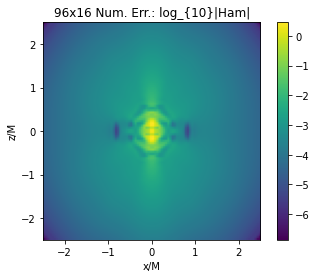

In [14]:
x96,y96,valuesCF96,valuesHam96 = np.loadtxt(os.path.join(outdir,'out96.txt')).T #Transposed for easier unpacking

pl_xmin = -2.5
pl_xmax = +2.5
pl_ymin = -2.5
pl_ymax = +2.5

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points96 = np.zeros((len(x96), 2))
for i in range(len(x96)):
    points96[i][0] = x96[i]
    points96[i][1] = y96[i]

grid96 = griddata(points96, valuesCF96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesCF96, (grid_x, grid_y), method='cubic')

grid96 = griddata(points96, valuesHam96, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points96, valuesHam96, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96x16 Num. Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("z/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next we check that indeed the numerical errors converge to zero as expected, using the fact that the Hamiltonian constraint violation should converge to zero with increasing resolution. See [the Scalar Wave Curvilinear tutorial notebook](Tutorial-Start_to_Finish-ScalarWaveCurvilinear_new_way.ipynb) for more documentation on measuring numerical convergence.

<Figure size 432x288 with 0 Axes>

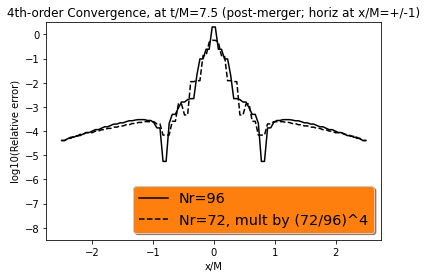

In [15]:
x72,y72,valuesCF72,valuesHam72 = np.loadtxt(os.path.join(outdir,'out72.txt')).T #Transposed for easier unpacking
points72 = np.zeros((len(x72), 2))
for i in range(len(x72)):
    points72[i][0] = x72[i]
    points72[i][1] = y72[i]

grid72 = griddata(points72, valuesHam72, (grid_x, grid_y), method='nearest')

griddiff_72_minus_96 = np.zeros((100,100))
griddiff_72_minus_96_1darray = np.zeros(100*100)
gridx_1darray_yeq0 = np.zeros(100)
grid72_1darray_yeq0 = np.zeros(100)
grid96_1darray_yeq0 = np.zeros(100)
count = 0
for i in range(100):
    for j in range(100):
        griddiff_72_minus_96[i][j] = grid72[i][j] - grid96[i][j]
        griddiff_72_minus_96_1darray[count] = griddiff_72_minus_96[i][j]
        if j==49:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid72_1darray_yeq0[i] = grid72[i][j] + np.log10((72./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("4th-order Convergence, at t/M=7.5 (post-merger; horiz at x/M=+/-1)")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid72_1darray_yeq0, 'k--', label='Nr=72, mult by (72/96)^4')
ax.set_ylim([-8.5,0.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 9: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide_new_way.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide_new_way.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [16]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide_new_way")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-
    Two_BHs_Collide_new_way.tex, and compiled LaTeX file to PDF file
    Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide_new_way.pdf
